
# **Introducción:**
En este trabajo desarrollamos un modelo de clasificación utilizando máquinas de vectores de soporte (SVM) con el objetivo de predecir el desempeño académico de estudiantes a partir de variables relacionadas con sus hábitos de vida y entorno personal. El enfoque principal es evaluar el impacto de tres hiperparámetros fundamentales del modelo (C, gamma y kernel) en su rendimiento predictivo.
Para lograrlo, hemos implementado un preprocesamiento integral que toma en cuenta la codificación de variables categóricas, la normalización de los datos numéricos y la transformación de la variable objetivo en una clasificación binaria (aprobado/no aprobado).
Finalmente, se analizan los efectos individuales de cada hiperparámetro sobre la precisión del modelo y presentamos los resultados usando métricas de rendimiento, matrices de confusión y visualizaciones comparativas, con el fin de identificar patrones consistentes con la teoría del algoritmo. Realizamos el experimento usand el conjunto de datos Student Habits vs Academic Performance, el cual nos proporciona una base adecuada para observar cómo factores del comportamiento estudiantil se relacionan con los resultados académicos y cómo un modelo SVM responde al ajuste de sus parámetros clave.


# **Diagrama de Flujo:**

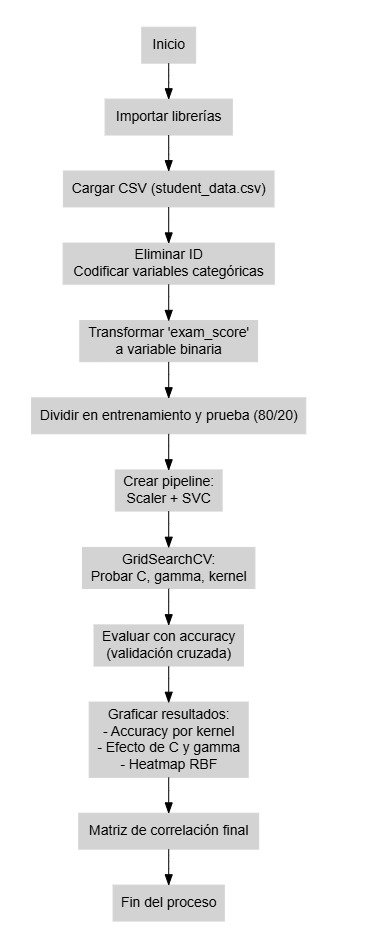

In [ ]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline


df = pd.read_csv('student_habits_performance.csv')

# Preprocesamiento
df = df.drop(columns=["student_id"])  # Quitar columna ID si existe
categorical_cols = df.select_dtypes(include="object").columns

# Codificación
le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

# Definir variables y etiquetas
X = df.drop("exam_score", axis=1)
y = (df["exam_score"] > 60).astype(int)  # Aprobado = 1, no aprobado = 0

# División de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelo + GridSearchCV
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC())
])

param_grid = {
    'svc__C': [0.1, 1, 10],
    'svc__gamma': [0.01, 0.1, 1],
    'svc__kernel': ['linear', 'rbf', 'poly']
}

grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)

# Análisis del rendimiento
results = pd.DataFrame(grid.cv_results_)
results = results[['mean_test_score', 'param_svc__C', 'param_svc__gamma', 'param_svc__kernel']]
results['param_svc__C'] = results['param_svc__C'].astype(float)
results['param_svc__gamma'] = results['param_svc__gamma'].astype(float)


# **Resultados:**


🔍 Rendimiento promedio por kernel:
  param_svc__kernel  mean_test_score
0            linear         0.906667
1              poly         0.795556
2               rbf         0.791250


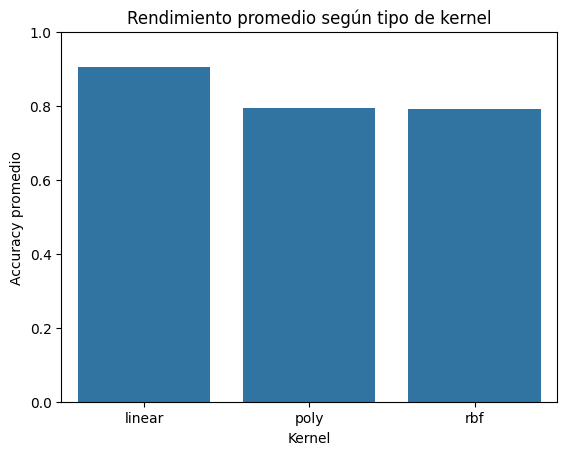

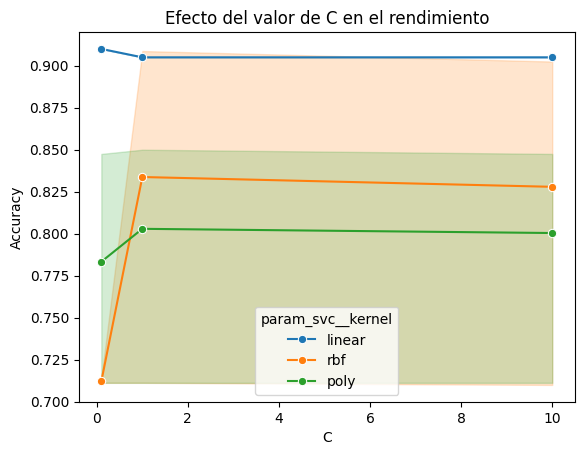

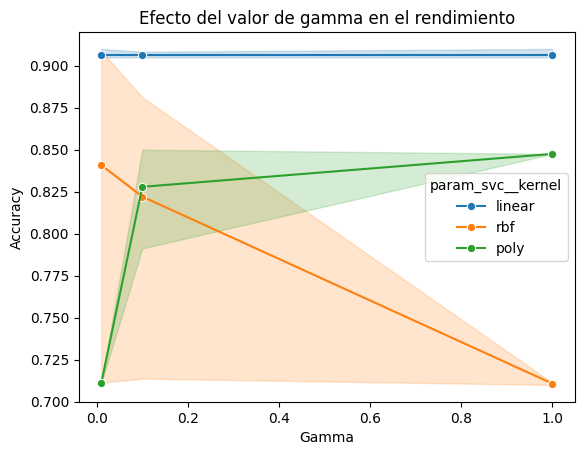

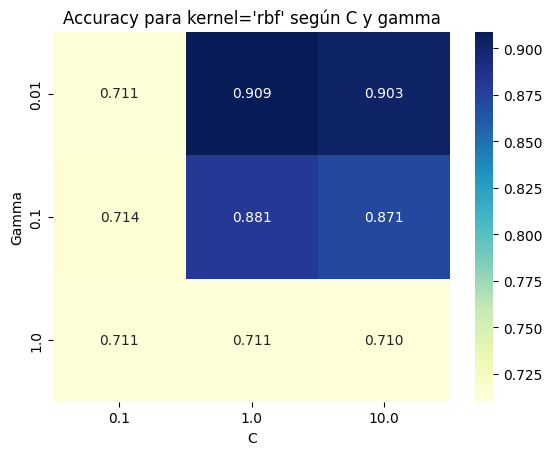

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


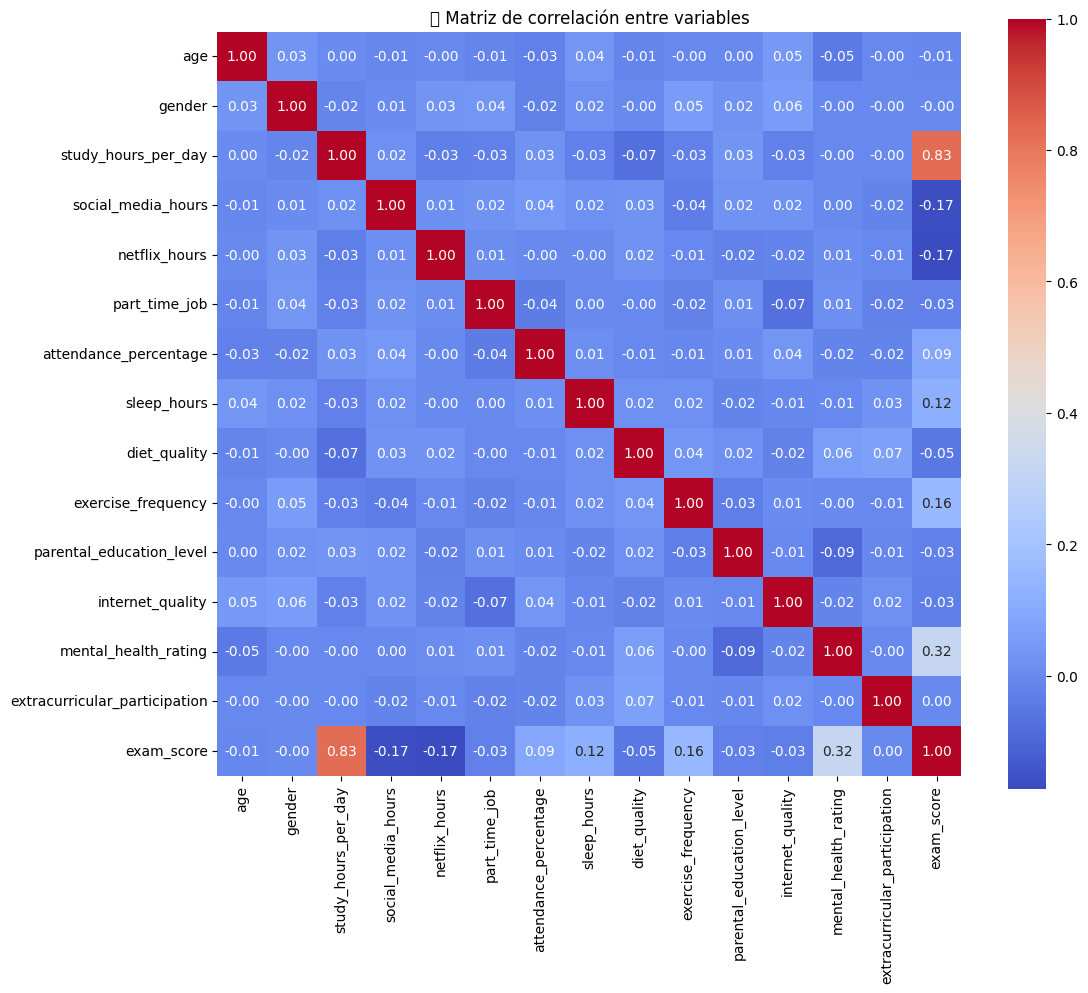

In [ ]:

# Promedio por kernel
kernel_avg = results.groupby('param_svc__kernel')['mean_test_score'].mean().reset_index()

print("\n🔍 Rendimiento promedio por kernel:")
print(kernel_avg.sort_values(by='mean_test_score', ascending=False))

# Accuracy por kernel
sns.barplot(data=kernel_avg, x='param_svc__kernel', y='mean_test_score')
plt.title("Rendimiento promedio según tipo de kernel")
plt.ylabel("Accuracy promedio")
plt.xlabel("Kernel")
plt.ylim(0, 1)
plt.show()

# Efecto de C
sns.lineplot(data=results, x='param_svc__C', y='mean_test_score', hue='param_svc__kernel', marker='o')
plt.title("Efecto del valor de C en el rendimiento")
plt.ylabel("Accuracy")
plt.xlabel("C")
plt.show()

# Efecto de gamma
sns.lineplot(data=results, x='param_svc__gamma', y='mean_test_score', hue='param_svc__kernel', marker='o')
plt.title("Efecto del valor de gamma en el rendimiento")
plt.ylabel("Accuracy")
plt.xlabel("Gamma")
plt.show()

# Mapa de calor para kernel RBF
rbf_results = results[results['param_svc__kernel'] == 'rbf']
heatmap_rbf = rbf_results.pivot(index='param_svc__gamma', columns='param_svc__C', values='mean_test_score')

sns.heatmap(heatmap_rbf, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("Accuracy para kernel='rbf' según C y gamma")
plt.xlabel("C")
plt.ylabel("Gamma")
plt.show()

# Matriz de correlación
correlation_matrix = df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("🔗 Matriz de correlación entre variables")
plt.show()


# **Discusión:**
Durante el desarrollo del trabajo, observamos diferencias claras en el rendimiento del modelo al modificar los hiperparámetros C, gamma y kernel, y vimos que estas diferencias fueron coherentes con lo que se espera desde la teoría de las Máquinas de Vectores de Soporte (SVM).
En cuanto al tipo de kernel, nos llamó la atención que el kernel lineal fue el que mejor rendimiento promedio ofreció, incluso por encima de rbf, que normalmente es más flexible. Esto nos sugiere que en este caso, las variables del dataset tienen relaciones lo suficientemente lineales como para que un modelo más simple funcione muy bien, sin necesidad de curvaturas complejas.
Respecto a C, pudimos confirmar que los valores intermedios o altos suelen mejorar el rendimiento, ya que el modelo penaliza más los errores, aunque también nos dimos cuenta que al aumentar demasiado C, la mejora se estabiliza, es decir, no siempre un C más alto significa mejor resultado. Esto concuerda con la idea de que hay un punto óptimo entre no penalizar nada y sobreajustarse.
El parámetro gamma, especialmente en el kernel RBF, fue el más sensible. Al usar valores bajos (como 0.01), el modelo fue capaz de generalizar bien. En cambio, cuando lo aumentamos a 1.0, la precisión bajó considerablemente. Esto se vio claramente en el mapa de calor, donde el mejor rendimiento se concentró en combinaciones con gamma bajo y C medio o alto. Como vimos en la teoría, gamma controla qué tan cerca deben estar los puntos para afectar la frontera de decisión; si es muy alto, el modelo puede sobreajustarse y perder capacidad de generalización.
La matriz de correlación entre variables reforzó que hay ciertos factores con fuerte relación con el desempeño académico, como las horas de estudio por día, lo que da sentido a la elección del dataset y respalda que el modelo esté aprendiendo sobre señales reales.

Algo que nos pareció interesante al revisar el trabajo de Chakrapani y Chitradevi fue que, al igual que nosotros, ellos también probaron diferentes configuraciones de SVM para predecir el rendimiento académico, y el kernel lineal fue el que dio mejores resultados, superando a los kernels rbf y poly. En su estudio, el modelo con kernel lineal alcanzó una precisión del 83.1% sin usar técnicas como boosting, lo que muestra que un enfoque más simple puede funcionar muy bien en ciertos contextos. Esto coincidió con lo que vimos en nuestro experimento ya que nosotros también obtuvimos la mayor precisión con el kernel lineal, por encima de rbf y poly, esto nos podría hacer pensar que cuando los datos tienen relaciones relativamente directas, no siempre es necesario usar kernels más complejos.

# **Conclusiones:**
Este trabajo nos ayudó a entender de forma práctica cómo los hiperparámetros C, gamma y kernel influyen en el rendimiento de un modelo SVM. Al ir probando distintas combinaciones y visualizando los resultados, pudimos ver que ajustar bien estos valores realmente hace una diferencia en la precisión del modelo.
Vimos que el kernel lineal funcionó mejor que los otros dos en este caso, lo cual tiene sentido porque los datos parecen tener relaciones bastante lineales. También notamos que un C intermedio fue suficiente para obtener buenos resultados, y que subirlo demasiado no siempre mejora el modelo, lo que coincide con lo que dice la teoría.
El parámetro gamma fue el más delicado ya que cuando usamos valores altos, sobre todo con el kernel RBF, el modelo se volvió muy específico a los datos de entrenamiento y bajó su rendimiento. Esto nos confirma que un gamma demasiado alto puede llevar al sobreajuste, mientras que uno más bajo permite generalizar mejor.
Además de todo lo técnico, esta experiencia nos permitió ver lo importante que es no quedarse con los valores por defecto del modelo y tomarse el tiempo de probar distintas combinaciones.

# **Bibliografía:**
Bobadilla, J. (2020). Machine Learning & Deep Learning. Madrid: Paraninfo.

Jayaanth Naath. (2023). Student Habits vs Academic Performance [Conjunto de datos]. Kaggle. https://www.kaggle.com/datasets/jayaantanaath/student-habits-vs-academic-performance

Chakrapani, P., & Chitradevi, D. (2022). Simulation of Machine Learning Techniques to Predict Academic Performance. Proceedings of the International Conference on Electronic Systems and Intelligent Computing (ICESIC). IEEE.